In [6]:
# Importing modules

import pandas as pd
import numpy as np

In [7]:
# Treating data

# Loading data
df = pd.read_parquet("BTC_features_clean.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27203 entries, 2017-12-15 22:00:00 to 2024-12-31 23:00:00
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                27203 non-null  float64
 1   high                27203 non-null  float64
 2   low                 27203 non-null  float64
 3   close               27203 non-null  float64
 4   volume              27203 non-null  float64
 5   quote_asset_volume  27203 non-null  float64
 6   number_of_trades    27203 non-null  float64
 7   taker_buy_base      27203 non-null  float64
 8   taker_buy_quote     27203 non-null  float64
 9   sma_7d              27203 non-null  float64
 10  sma_30d             27203 non-null  float64
 11  sma_50d             27203 non-null  float64
 12  sma_100d            27203 non-null  float64
 13  return              27203 non-null  float64
 14  volatility_20       27203 non-null  float64
 15  volatility_50     

In [8]:
# Transforming data into inputs for the model

def make_windows(df, input_len=168, output_horizons=[1, 3, 6], target_col="close"):
    """
    Génère les fenêtres (X, Y) pour l'entraînement d'un modèle séquentiel.
    
    df : DataFrame Pandas (index = datetime, colonnes = features)
    input_len : longueur de la fenêtre d'entrée (en heures)
    output_horizons : horizons de prédiction (en heures)
    target_col : colonne de référence pour la target (ex. 'close')
    
    Retourne :
        X : np.array (n_samples, input_len, n_features)
        Y : np.array (n_samples, len(output_horizons))
    """
    feature_cols = [c for c in df.columns if c != target_col]
    data = df[feature_cols].values
    target = df[target_col].values
    n_features = data.shape[1]

    X, Y = [], []
    max_h = max(output_horizons)

    for t in range(len(df) - input_len - max_h):
        # Fenêtre d'entrée
        x_window = data[t : t + input_len]

        # Targets en rendements relatifs
        y_window = []
        current_price = target[t + input_len - 1]
        for h in output_horizons:
            future_price = target[t + input_len + h - 1]
            y_window.append(future_price / current_price - 1)

        X.append(x_window)
        Y.append(y_window)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    print(f"✅ make_windows: X={X.shape}, Y={Y.shape}")
    return X, Y

In [9]:
import numpy as np

def make_windows_log_return(df, input_len=168, output_horizons=[1, 3, 6], target_col="close"):
    """
    Génère les fenêtres (X, Y) pour l'entraînement avec rendements log comme target.
    
    df : DataFrame Pandas
    input_len : longueur de la fenêtre d'entrée (en heures)
    output_horizons : horizons de prédiction (en heures)
    target_col : colonne de référence (ex. 'close')
    
    Retourne :
        X : np.array (n_samples, input_len, n_features)
        Y : np.array (n_samples, len(output_horizons)) = rendements log
    """
    feature_cols = [c for c in df.columns if c != target_col]
    data = df[feature_cols].values
    target = df[target_col].values
    n_features = data.shape[1]

    X, Y = [], []
    max_h = max(output_horizons)

    for t in range(len(df) - input_len - max_h):
        # Fenêtre d'entrée
        x_window = data[t : t + input_len]

        # Rendements log comme targets
        y_window = []
        current_price = target[t + input_len - 1]
        for h in output_horizons:
            future_price = target[t + input_len + h - 1]
            log_return = np.log(future_price / current_price)
            y_window.append(log_return)

        X.append(x_window)
        Y.append(y_window)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    print(f"✅ make_windows_log_return: X={X.shape}, Y={Y.shape}")
    return X, Y


In [10]:
# Inputs and Outputs generations for the whole dataset
#X, Y = make_windows(df, input_len=168, output_horizons=[1, 3, 6], target_col="close")
X, Y = make_windows_log_return(df, input_len=168, output_horizons=[1, 3, 6], target_col="close")

✅ make_windows_log_return: X=(27029, 168, 24), Y=(27029, 3)


In [11]:
# Split the dataset for train, validation and test.

def time_series_split(X, Y, train_size=0.7, val_size=0.15):
    """
    Split temporel des données en train, val et test.
    """
    n = len(X)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    
    X_train, Y_train = X[:train_end], Y[:train_end]
    X_val,   Y_val   = X[train_end:val_end], Y[train_end:val_end]
    X_test,  Y_test  = X[val_end:], Y[val_end:]
    
    print(f"Train: {X_train.shape}, {Y_train.shape}")
    print(f"Val:   {X_val.shape}, {Y_val.shape}")
    print(f"Test:  {X_test.shape}, {Y_test.shape}")
    
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

In [12]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = time_series_split(X, Y)

Train: (18920, 168, 24), (18920, 3)
Val:   (4054, 168, 24), (4054, 3)
Test:  (4055, 168, 24), (4055, 3)


## INFORMER CREATION

### Etape 0: Normalization of the features

On utilise ici des moyennes sur le train car c'est la norme d'utilisation pour éviter le data leaking.

In [13]:
import numpy as np

# Suppose que tu as déjà X, Y puis le split
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = time_series_split(X, Y)

# Stats uniquement sur le train (pas de fuite d'info)
feat_mean = X_train.mean(axis=(0,1), keepdims=True)
feat_std  = X_train.std(axis=(0,1), keepdims=True) + 1e-8

X_train_n = (X_train - feat_mean) / feat_std
X_val_n   = (X_val   - feat_mean) / feat_std
X_test_n  = (X_test  - feat_mean) / feat_std


Train: (18920, 168, 24), (18920, 3)
Val:   (4054, 168, 24), (4054, 3)
Test:  (4055, 168, 24), (4055, 3)


### Etape 1 : Conding ProbSparse attention -- Multi-Head attention for Informers.

On regarde chaque étape du call de la classe

#### Etape 0 :

On récupère dans `B` et `T` la taille du batch et la taille de la séquence respectivement.

#### Etape 1 :

On commence par projetter linéairement `X` sur `Q`, `K` et `V` à l'aide de différentes matrices. Mathématique, on a:
$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

X étant de shape `(B, T, d_model ou d_in)`, nous obtenons des objets `Q`, `K` et `V` de taille `(B, T, d_model)`.

Les poids des matrices $W_Q$, $W_K$ et $W_V$ (de shape `(d_in, d_model)`) sont entraînables.

#### Etape 2 : 

On divise notre attention en multi-tête, comme pour un transformer. Ce nombre de tête est défini par `num_head`. La valeur par défault de la classe est 4. Ainsi, on passe d'une information de taille `d_model` à `d_k` avec `d_model = h * d_k` présent dans chacune des `num_head` têtes, avec `d_k` défini tel que:

$$
d_k = \frac{d_{\text{model}}}{\text{num\_heads}}
$$

La fonction `split_heads` prend en entrée un tenseur et fais cette séparation en `num_head` têtes de taille `d_k`. Ainsi, on l'applique à `Q`, `K` et `V`. Ils deviennent des objets de shape `(B, T, h, d_k)`.

#### Etape 3: 

L'idée est de traîté chaque tête comme une séquence indépendante. Ainsi, on va applatir notre vecteur sur la dimension `B`et `h`, de manière à avoir un objet de shape `(B*h, T, d_k)`. On stocks ces nouveaux objets dans `Q_`, `K_` et `V_` pour respectivement les objets `Q`, `K` et `V`.

#### Etape 4:

D'abord, on applique une **normalisation L2** sur `Q_` et `K_`, que l'on stock respectivement dans `norm_q` et `norm_k`. Cette opération met chaque vecteur à norme 1, ce qui permet d’interpréter leur produit scalaire comme une **similarité cosinus**. On a donc :
$$
||q_i|| = ||k_j|| = 1 \,
$$
avec $||q_i||$ et $||k_j||$, les éléments $i$ et $j$ correspondant à la dimension `T` de `norm_q` et `norm_k` respectivement.

Ensuite, nous pouvons calculer les scores pour les objets `norm_q` et `norm_k`. On nomme ceci `scores` car on regarde, pour chaque $q_i$, un score de similarité avec chaque $k_j$. Les scores sont calculés de cette manière :
$$
s_i = \text{max} \frac{q_i \cdot k_j}{||q_i|| \times ||k_j||}
$$

Dans notre code, nous calculons d'abord tous les $s_{i,j}$, et ensuite nous prenons le $s_i$ max sur pour chaque $j$ avec respectivement les variales `scores`et `max_scores`.
De fait, `max_scores` représente donc la capacité de la query $i$ à pointer au moins une key pertinente.

#### Etape 5:

Maintenant que l'on connait l'ordre d'importance des query grâce à `max_scores`, on doit maintenant décider combien de queries garder. Cela se paramètre grâce à la variable `u` dans la classe et dans cette étape du call.

On défini alors `u` par rapport à lui même et `T` en utilisant un `tf.minimum`sur ces deux objets. Ainsi, on a `u` défini par lui même si $u \lt T$ ou par `T` si $u \gt T$.

Dans le papier, on pose généralement $u \approx O \left( \ln T\right)$. Un bon nombre pour `u`d'une valeur de 168 est donc d'environ 10-20.

La dernière étape consiste à garder les `u` indices des queries les plus importantes. On va d'abord déterminer ces indices dans `top_idx` en utilisant `max_scores` et `u`, donnant un objet de taille `(B*h, u)`. 

#### Etape 6:

Ici, l'idée est d'utiliser `top_idx`, les indices des queries les plus importantes, pour récupérer les queries les plus importante stockées dans `Q_`. On les stocke dans `Q_sel` de shape `(B*h, u, d_k)`.

#### Etape 7:

Ici, on utilise un processus de Scaled dot-product attention standard. Pour rappel, il est défini par:
$$
\text{Attention}(Q,K,V)= \text{Softmax}\left( \frac{QK^\intercal}{​\sqrt{d_k}}\right) V
$$

Comme pour un cas classique, la sortie est multiplié par les values `V_`, donnant un objet de shape identique aux nombres de queries selectionnée (`Q_sel`), soit `(B*h, u, d_k)`. Je précise que l'on prend `u` sorties seulement, non `T`.

#### Etape 8:

Ici, on doit garder en tête que la sortie de notre couche doit être de shape `(B*h, T, d_k)`. Cependant, on a un `out`de shape `(B*h, u, d_k)`. La solution est tout simplement de placer `out` dans un tenseur vide `out_full` rempli de zéros de shape `(B*h, T, d_k)`.

#### Etape 9:

On doit replacer les résultats calculés pour les `u` queries retenues (`out`) dans la séquence complète `out_full` de taille `(B*h, T, d_k)`. Pour cela, on utilise les indices de `top_idx` et un “scatter update” dans TensorFlow.  

On commence par générer les indices de batch×head associés à chaque query sélectionnée, que l’on stocke dans `batch_idx`. Ensuite, on les empile avec les indices temporels `top_idx` pour former `idx`, un objet de shape `(B*h, u, 2)` contenant les couples `(batch_id, time_step)` pour chaque query retenue.  

Enfin, on applique `tf.tensor_scatter_nd_update`, qui va insérer les vecteurs calculés (`out`) aux bonnes positions de la séquence complète `out_full`, en laissant des zéros pour toutes les autres positions (les queries non retenues).  

On obtient ainsi un tenseur `out_full` de shape `(B*h, T, d_k)`, où les top-u queries ont été replacées correctement dans la séquence complète.

#### Etape 10:

À présent, notre tenseur `out_full` est de shape `(B*h, T, d_k)`, où chaque séquence contient les résultats pour les `u` queries retenues et des zéros ailleurs.  

On doit maintenant revenir à la shape attendue par les blocs suivants de l’encodeur : `(B, T, d_model)`.  

Pour cela :  
1. On reshape `out_full` en `(B, T, h, d_k)`.  
2. On concatène les têtes sur la dernière dimension, donnant un tenseur `(B, T, d_model)`, avec `d_model = h * d_k`.  
3. Enfin, on applique une dernière projection linéaire avec une matrice entraînable `W_o ∈ ℝ^{d_model × d_model}` pour mélanger l’information entre les différentes têtes et assurer la cohérence de l’espace latent.  

Le tenseur final de shape `(B, T, d_model)` peut alors être passé à la suite du bloc encodeur (normalisation, feed-forward, etc.).  



In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class ProbSparseAttention(layers.Layer):
    """
    Version pédagogique de ProbSparse Self-Attention.
    Sélectionne seulement les top-u queries les plus informatives.
    """
    def __init__(self, d_model, num_heads=4, dropout=0.1, u=15, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model doit être divisible par num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.dropout = dropout
        self.u = u  # nombre de queries gardées

        # Projections linéaires
        self.W_q = layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.W_k = layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.W_v = layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.W_o = layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-4))

        self.drop = layers.Dropout(dropout)

    def call(self, x, training=False):
        """
        x: (batch, T, d_model)
        """
        # 0. Récupération de la taille du batch B et de la séquence T
        B, T, _ = tf.unstack(tf.shape(x))

        # 1. Projeter en Q, K, V
        Q = self.W_q(x)  # (B, T, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # 2. Découper en têtes
        def split_heads(tensor):
            return tf.reshape(tensor, (B, T, self.num_heads, self.d_k))  # (B, T, h, d_k)

        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)

        # 3. Aplatir batch*têtes
        Q_ = tf.reshape(Q, (B*self.num_heads, T, self.d_k)) # (B*h, T, d_k)
        K_ = tf.reshape(K, (B*self.num_heads, T, self.d_k))
        V_ = tf.reshape(V, (B*self.num_heads, T, self.d_k))

        # 4. Calcul score de sparsité (max similitude)
        norm_q = tf.nn.l2_normalize(Q_, axis=-1)
        norm_k = tf.nn.l2_normalize(K_, axis=-1)
        scores = tf.matmul(norm_q, norm_k, transpose_b=True)  # (B*h, T, T)
        max_scores = tf.reduce_max(scores, axis=-1)  # (B*h, T)

        # 5. Top-u queries
        u = tf.minimum(self.u, T)
        top_idx = tf.argsort(max_scores, axis=-1, direction="DESCENDING")[:, :u]  # (B*h, u)

        # 6. Extraire les queries sélectionnées
        Q_sel = tf.gather(Q_, top_idx, batch_dims=1)  # (B*h, u, d_k)

        # 7. Attention seulement sur Q_sel vs tous K,V
        attn_weights = tf.matmul(Q_sel, K_, transpose_b=True) / tf.math.sqrt(tf.cast(self.d_k, tf.float32))
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
        attn_weights = self.drop(attn_weights, training=training)

        out = tf.matmul(attn_weights, V_)  # (B*h, u, d_k)

        # 8. Reconstruire la séquence complète (remplir les queries non sélectionnées par 0)
        out_full = tf.zeros_like(Q_)  # (B*h, T, d_k)

        # 9. indices pour scatter update
        batch_idx = tf.repeat(tf.range(B*self.num_heads)[:, None], u, axis=1)  # (B*h, u)
        idx = tf.stack([batch_idx, top_idx], axis=-1)  # (B*h, u, 2)

        out_full = tf.tensor_scatter_nd_update(out_full, tf.reshape(idx, (-1, 2)), tf.reshape(out, (-1, self.d_k)))

        # 10. Reconstruire (B, T, d_model)
        out_full = tf.reshape(out_full, (B, T, self.d_model))
        return self.W_o(out_full)


2025-09-05 14:22:52.042211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Etape 2: Positional encoding

Ici, on fait comme avec le transformer. Se référer à la documentation. On code le **positional encoding**.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class SinusoidalPE(layers.Layer):
    """Encodage positionnel sin/cos (Vaswani et al., 2017)."""
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        # x: (B, T, d_model) — B=batch, T=longueur séquence, d_model=dim embedding
        T = tf.shape(x)[1]
        d = self.d_model

        # positions: [0, 1, ..., T-1]  shape (T, 1)
        pos = tf.cast(tf.range(T)[:, None], tf.float32)

        # indices de dimensions: [0, 1, ..., d-1] shape (1, d)
        i = tf.cast(tf.range(d)[None, :], tf.float32)

        # angle_rates = 1 / 10000^{2i/d}
        angle_rates = tf.pow(10000.0, - (tf.floor(i/2.0) * 2.0) / tf.cast(d, tf.float32))
        # angle_rads = pos * angle_rates  shape (T, d)
        angle_rads = pos * angle_rates

        # Appliquer sin sur dimensions paires (2k), cos sur impaires (2k+1)
        sines = tf.sin(angle_rads[:, 0::2])
        coses = tf.cos(angle_rads[:, 1::2])

        # Recomposer en (T, d): intercaler sin/cos
        pe = tf.concat([tf.reshape(tf.stack([sines, coses], axis=-1), (T, -1)),
                        tf.zeros((T, d - tf.shape(tf.reshape(tf.stack([sines, coses], axis=-1), (T, -1)))[1]))], axis=-1)
        pe = pe[:, :d]  # sécurité si d est impair

        return x + pe[None, ...]  # broadcast sur le batch


### Etape 3: EncoderLayer (Version Informer)

```mermaid
flowchart TD
    A[Entrée X (B,T,d_model)] --> B[ProbSparse Self-Attention]
    B --> C[Résidu: X + Attn(X)]
    C --> D[LayerNorm]
    D --> E[Feed Forward Network (Dense -> ReLU -> Dense)]
    E --> F[Résidu: D + FFN(D)]
    F --> G[LayerNorm]
    G --> H[Sortie (B,T,d_model)]

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff=512, dropout=0.1, u=20):
        super().__init__()
        self.attn = ProbSparseAttention(d_model, num_heads, dropout=dropout, u=u)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            layers.Dropout(dropout),
            layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop = layers.Dropout(dropout)

    def call(self, x, training=False):
        # 1. Attention + résidu
        attn_out = self.attn(x, training=training)
        x = self.norm1(x + self.drop(attn_out, training=training))

        # 2. FeedForward + résidu
        ffn_out = self.ffn(x, training=training)
        x = self.norm2(x + self.drop(ffn_out, training=training))

        return x


### Etape 4: DistillingLayer

In [17]:
class DistillingLayer(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.conv = tf.keras.layers.Conv1D(
            filters=d_model, kernel_size=3, padding="same", activation="relu"
        )
        self.pool = tf.keras.layers.MaxPooling1D(pool_size=2)

    def call(self, x):
        # x: (B, T, d_model)
        x = self.conv(x)   # (B, T, d_model)
        x = self.pool(x)   # (B, T/2, d_model)
        return x


### Etape 4: InformerEncoder

Attention: Ici, l'output est de shape `(B, T', d_model)` avec `T'` inférieur à `T` à cause du processus de distillation.

In [18]:
class InformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff=512, num_layers=2, dropout=0.1, u=20):
        super().__init__()
        self.layers = []
        for i in range(num_layers):
            self.layers.append(EncoderLayer(d_model, num_heads, d_ff, dropout, u))
            # Ajouter une distillation sauf après la dernière couche
            if i < num_layers - 1:
                self.layers.append(DistillingLayer(d_model))

    def call(self, x, training=False):
        # x: (B, T, d_model)
        for layer in self.layers:
            x = layer(x, training=training)
        return x  # (B, T', d_model) avec T' réduit par distillation


### Etape 5: Predictions

L'idée ici est de passer de l'Informer encodeur avec une sortie de shape `(B, T', d_model)` aux prédictions de shape `(B, n_horizons)` avec `n_horizons`étant le vecteur de prédictions, soit par exemple `(1h, 6h, 12h, 1d, 1w)`.

In [19]:
class PredictionHead(tf.keras.layers.Layer):
    def __init__(self, d_model, horizons, dropout=0.1):
        super().__init__()
        self.pool = tf.keras.layers.GlobalAveragePooling1D()
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(horizons, kernel_regularizer=tf.keras.regularizers.l2(1e-4))  # sortie multi-horizon
        ])

    def call(self, x, training=False):
        # x: (B, T', d_model)
        x = self.pool(x)       # (B, d_model)
        x = self.ffn(x, training=training)  # (B, horizons)
        return x

### Etape 6: Loss-function

In [20]:
# RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# MAPE
def mape(y_true, y_pred):
    epsilon = 1e-8
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100


### Etape 7: Modele declaration

In [21]:
class Informer(tf.keras.Model):
    def __init__(self, d_model, num_heads, d_ff, num_layers, horizons, dropout=0.1, u=20):
        super().__init__()
        self.input_proj = tf.keras.layers.Dense(d_model)  # projette tes features -> d_model
        self.pe = SinusoidalPE(d_model)  # positional encoding
        self.encoder = InformerEncoder(d_model, num_heads, d_ff, num_layers, dropout, u)
        self.head = PredictionHead(d_model, horizons, dropout)

    def call(self, x, training=None):
        # x: (B, T, d_model) déjà normalisé
        x = self.input_proj(x)  # projette les features -> d_model (B, T, d_model)
        x = self.pe(x)                       # ajoute l'encodage positionnel
        x = self.encoder(x, training=training)  # encodeur Informer
        x = self.head(x, training=training)     # prédicteur multi-horizon
        return x  # (B, horizons)


### Etape 8: Modele creation and compilation

In [22]:
# Créer ton modèle
model = Informer(
    d_model=64,
    num_heads=4,
    d_ff=256,
    num_layers=2,
    horizons=3,
    dropout=0.2,
    u=20
)

I0000 00:00:1757082178.645900    1017 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6


In [23]:
# Modele compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=[rmse]
)


### Etape 9: Checkpoint

In [24]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="informer_best.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

### Etape 10: Training

In [25]:
# Logger clair
csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv", append=False)

# Entraînement
history = model.fit(
    X_train_n, Y_train,
    validation_data=(X_val_n, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cb, csv_logger],
    verbose=1
)

2025-09-05 14:23:06.892184: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 305141760 exceeds 10% of free system memory.
2025-09-05 14:23:07.354849: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 305141760 exceeds 10% of free system memory.


Epoch 1/100


2025-09-05 14:23:15.880166: I external/local_xla/xla/service/service.cc:163] XLA service 0x764c2000b3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-05 14:23:15.880209: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-05 14:23:16.093344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-05 14:23:17.117410: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-05 14:23:18.028807: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-05 14:23:19.406448: I e

  3/592 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - loss: 0.2480 - rmse: 0.5424   

I0000 00:00:1757082217.741377    1544 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/592 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1150 - rmse: 0.1500

2025-09-05 14:23:45.579979: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-05 14:23:45.580115: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-05 14:23:45.580163: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-05 14:23:45.580184: I external/l

592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1149 - rmse: 0.1499

2025-09-05 14:24:07.747621: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 65382912 exceeds 10% of free system memory.
2025-09-05 14:24:07.846102: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 65382912 exceeds 10% of free system memory.
2025-09-05 14:24:09.192473: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2025-09-05 14:24:09.442061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 8 bytes spill stores, 8 bytes spill loads

2025-09-05 14:24:14.608875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 4 bytes spill stores, 4 bytes spill


Epoch 1: val_loss improved from None to 0.08695, saving model to informer_best.weights.h5
592/592 ━━━━━━━━━━━━━━━━━━━━ 71s 69ms/step - loss: 0.1000 - rmse: 0.0845 - val_loss: 0.0870 - val_rmse: 0.0555
Epoch 2/100
590/592 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0806 - rmse: 0.0223
Epoch 2: val_loss improved from 0.08695 to 0.06607, saving model to informer_best.weights.h5
592/592 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0758 - rmse: 0.0200 - val_loss: 0.0661 - val_rmse: 0.0225
Epoch 3/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0615 - rmse: 0.0165
Epoch 3: val_loss improved from 0.06607 to 0.04861, saving model to informer_best.weights.h5
592/592 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0572 - rmse: 0.0161 - val_loss: 0.0486 - val_rmse: 0.0181
Epoch 4/100
590/592 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0448 - rmse: 0.0145
Epoch 4: val_loss improved from 0.04861 to 0.03461, saving model to informer_best.weights.h5
592/592 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - los

Premier entraînement:

```
loss: 2.9735e-04 - mape: 2053.2068 - rmse: 0.0227 - val_loss: 0.0051 - val_mape: 40356.2539 - val_rmse: 0.0888
```

Ajout de régularisation L2 et dropout de 0.2

```
Epoch 100: val_loss improved from 0.00208 to 0.00190, saving model to informer_best.weights.h5
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 9.2653e-04 - mape: 994.1317 - rmse: 0.0305 - val_loss: 0.0019 - val_mape: 12794.3789 - val_rmse: 0.0497
```

-> Bon entraînement, mais la prédiction sur une semaine est exagérée. Réduction des horizons à 4 : on garde que 1h, 6h, 12h, 24h.

```
Epoch 100: val_loss did not improve from 0.00028
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.2878e-04 - mape: 1616.7111 - rmse: 0.0255 - val_loss: 4.4962e-04 - val_mape: 1895.2616 - val_rmse: 0.0194
```

### Analyse résultats log

In [26]:
# Prédictions normalisées (rendements relatifs)
Y_pred = model.predict(X_test_n, batch_size=32)

2025-09-05 14:36:16.576096: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 65399040 exceeds 10% of free system memory.


114/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-09-05 14:36:22.455619: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 4 bytes spill stores, 4 bytes spill loads

2025-09-05 14:36:22.803045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2025-09-05 14:36:22.816942: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-09-05 14:36:22.914577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 4 bytes spill stores, 4 bytes spill loads

2025-09-05 14:36:23.231868: I external/local_xla/xla/stre

127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step


In [29]:
target = df["close"].values
X, Y = make_windows_log_return(df, input_len=168, output_horizons=[1,3,6])

# Split
split_idx = int(len(X) * 0.85)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Recalcul des current_prices pour chaque fenêtre
current_prices = []
max_h = max([1,3,6])  # horizons
for t in range(len(df) - 168 - max_h):
    current_price = target[t + 168 - 1]
    current_prices.append(current_price)
current_prices = np.array(current_prices, dtype=np.float32)

# Découpe train/test
current_prices_train = current_prices[:split_idx]
current_prices_test  = current_prices[split_idx:]

✅ make_windows_log_return: X=(27029, 168, 24), Y=(27029, 3)


In [30]:
# Reconstruction en prix
price_pred = current_prices_test[:, None] * np.exp(Y_pred)
price_true = current_prices_test[:, None] * np.exp(Y_test)

In [47]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def plot_h1_pred_true_with_naive(
    df_index: pd.DatetimeIndex,
    input_len: int,
    split_idx: int,
    price_true_h1: np.ndarray,      # shape (N_test,)
    price_pred_h1: np.ndarray,      # shape (N_test,)
    current_prices_test: np.ndarray # shape (N_test,)
):
    """
    Trace pour l'horizon +1h :
      - Vrai prix à t+1h
      - Prix prédit à t+1h
      - Baseline naïve: prix courant à t, mais affiché à t+1h (décalé d'1h)

    Paramètres
    ----------
    df_index : DatetimeIndex complet de ton DataFrame (train + test)
    input_len : longueur de la fenêtre d'entrée (heures)
    split_idx : indice de split sur les fenêtres (même que pour X/Y)
    price_true_h1 : vrai prix reconstruit pour +1h (test) -> shape (N_test,)
    price_pred_h1 : prix prédit reconstruit pour +1h (test) -> shape (N_test,)
    current_prices_test : prix courant (dernier point d'entrée) correspondant à chaque fenêtre test -> shape (N_test,)
    """

    N_test = len(price_true_h1)
    assert price_pred_h1.shape == (N_test,)
    assert current_prices_test.shape == (N_test,)

    # Horodatage du "prix courant" pour chaque fenêtre test :
    # Fenêtre globale t va de 0 à (nb_fenetres_tot-1). Pour la partie test, t = split_idx + j
    # Le prix courant correspond à l'index df_index[t + input_len - 1]
    t_global = np.arange(split_idx, split_idx + N_test)
    current_ts = df_index[t_global + input_len - 1]

    # Horodatage futur pour +1h
    future_ts = current_ts + pd.Timedelta(hours=1)

    fig = go.Figure()

    # Vrai prix à t+1h
    fig.add_trace(go.Scatter(
        x=future_ts, y=price_true_h1,
        mode="lines+markers",
        name="Vrai prix (+1h)",
        marker=dict(size=4, symbol="circle")
    ))

    # Prix prédit à t+1h
    fig.add_trace(go.Scatter(
        x=future_ts, y=price_pred_h1,
        mode="lines+markers",
        name="Prix prédit (+1h)",
        line=dict(dash="dot"),
        marker=dict(size=4, symbol="x")
    ))

    # Baseline naïve : prix courant, mais tracé à t+1h (décalé)
    fig.add_trace(go.Scatter(
        x=future_ts, y=current_prices_test,
        mode="lines+markers",
        name="Naïf: prix courant décalé (+1h)",
        line=dict(dash="dash"),
        marker=dict(size=4, symbol="triangle-up")
    ))

    fig.update_layout(
        title="Horizon +1h : Vrai vs Prédit vs Baseline naïve (prix courant décalé)",
        xaxis_title="Temps",
        yaxis_title="Prix BTC (USD)",
        template="plotly_dark",
        legend=dict(x=0, y=1),
        # xaxis=dict(rangeslider=dict(visible=True))
    )

    fig.show()

    

# Sélectionne la colonne 0 si tu as (N_test, 3) pour +1h,+3h,+6h
price_true_h1 = price_true[:, 0]
price_pred_h1 = price_pred[:, 0]

plot_h1_pred_true_with_naive(
    df_index=df.index,          # l'index DatetimeIndex complet
    input_len=168,              # ton input_len
    split_idx=split_idx,        # le même split que pour X/Y
    price_true_h1=price_true_h1,
    price_pred_h1=price_pred_h1,
    current_prices_test=current_prices_test
)


In [ ]:
# disons que X_test.shape = (N, input_len, n_features)
# on récupère le "dernier prix courant" pour chaque fenêtre
target = df["close"].values
current_prices = target[input_len-1 : input_len-1+len(Y_pred_test)]

# reconstruction
price_preds = current_prices[:, None] * np.exp(Y_pred)

In [27]:
def reconvert_to_prices(Y_pred, X_test, feat_mean, feat_std, df):
    # Index de la colonne "close"
    target_idx = list(df.columns).index("close")
    mean = feat_mean[0,0,target_idx]
    std = feat_std[0,0,target_idx]

    # Dernier prix connu = close à t0
    current_prices = X_test[:, -1, target_idx] * std + mean  # (N,)

    # Reconstruire les prix (rendement -> prix)
    # Y_true_real = (Y_true + 1) * current_prices[:, None]
    # Y_pred_real = (Y_pred + 1) * current_prices[:, None]
    Y_pred_real = np.exp(Y_pred) * current_prices

    return Y_pred_real, current_prices

Y_pred_real, current_prices = reconvert_to_prices(
    Y_pred, X_test_n, feat_mean, feat_std, df
)

ValueError: operands could not be broadcast together with shapes (4055,3) (4055,) 

### Analyse des résultats

In [135]:
# Prédictions normalisées (rendements relatifs)
Y_pred = model.predict(X_test_n, batch_size=32)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [136]:
def reconvert_to_prices(Y_pred, Y_true, X_test, feat_mean, feat_std, df):
    # Index de la colonne "close"
    target_idx = list(df.columns).index("close")
    mean = feat_mean[0,0,target_idx]
    std = feat_std[0,0,target_idx]

    # Dernier prix connu = close à t0
    current_prices = X_test[:, -1, target_idx] * std + mean  # (N,)

    # Reconstruire les prix (rendement -> prix)
    Y_true_real = (Y_true + 1) * current_prices[:, None]
    Y_pred_real = (Y_pred + 1) * current_prices[:, None]

    return Y_pred_real, Y_true_real, current_prices

Y_pred_real, Y_true_real, current_prices = reconvert_to_prices(
    Y_pred, Y_test, X_test_n, feat_mean, feat_std, df
)


In [157]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_horizons(Y_true_real, Y_pred_real, horizons=[1, 3, 6]):
    results = {}
    for i, h in enumerate(horizons):
        y_true = Y_true_real[:, i]
        y_pred = Y_pred_real[:, i]

        # MAE et RMSE
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Direction accuracy dans le temps
        real_dir = np.sign(np.diff(y_true))
        pred_dir = np.sign(np.diff(y_pred))
        dir_acc = np.mean(real_dir == pred_dir) * 100

        results[h] = {"MAE": mae, "RMSE": rmse, "DirAcc": dir_acc}

    return results

# Exemple d'utilisation :
results = evaluate_horizons(Y_true_real, Y_pred_real, horizons=[1, 3, 6])
for h, metrics in results.items():
    print(f"⏩ Horizon {h}h")
    print(f"   📊 MAE: {metrics['MAE']:.2f} $")
    print(f"   📊 RMSE: {metrics['RMSE']:.2f} $")
    print(f"   📈 Direction accuracy: {metrics['DirAcc']:.2f} %")
    print()


⏩ Horizon 1h
   📊 MAE: 6.83 $
   📊 RMSE: 19.78 $
   📈 Direction accuracy: 99.41 %

⏩ Horizon 3h
   📊 MAE: 12.25 $
   📊 RMSE: 32.35 $
   📈 Direction accuracy: 99.46 %

⏩ Horizon 6h
   📊 MAE: 17.21 $
   📊 RMSE: 43.69 $
   📈 Direction accuracy: 99.63 %



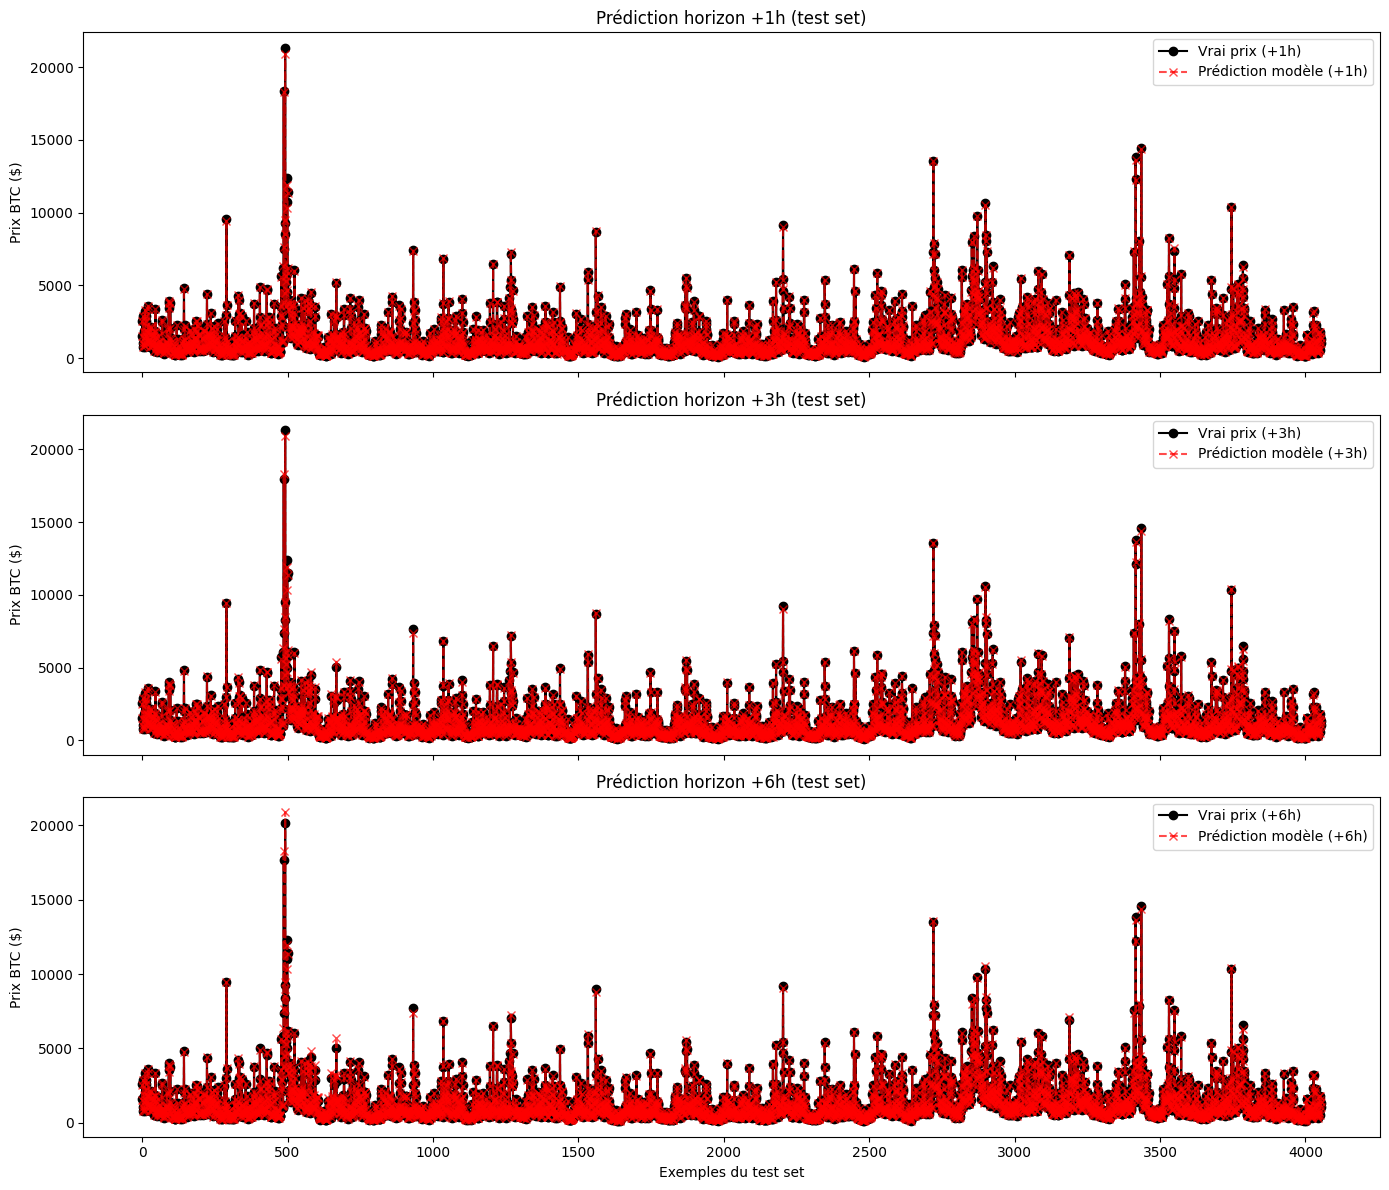

In [160]:
def plot_test_predictions(Y_true_real, Y_pred_real, horizons=[1, 3, 6], n_points=None):
    """
    Trace vrai prix vs prédiction sur le test set pour chaque horizon.
    
    n_points : nombre d'exemples à afficher (None = tout le test set).
    """
    n_h = len(horizons)
    fig, axes = plt.subplots(n_h, 1, figsize=(14, 4*n_h), sharex=True)

    if n_h == 1:
        axes = [axes]  # cas 1 seul subplot

    for i, h in enumerate(horizons):
        y_true = Y_true_real[:, i]
        y_pred = Y_pred_real[:, i]

        if n_points is not None:
            y_true = y_true[:n_points]
            y_pred = y_pred[:n_points]

        axes[i].plot(y_true, "o-", label=f"Vrai prix (+{h}h)", color="black")
        axes[i].plot(y_pred, "x--", label=f"Prédiction modèle (+{h}h)", color="red", alpha=0.7)

        axes[i].set_title(f"Prédiction horizon +{h}h (test set)")
        axes[i].set_ylabel("Prix BTC ($)")
        axes[i].legend()

    plt.xlabel("Exemples du test set")
    plt.tight_layout()
    plt.show()

# Exemple : tout le test set
plot_test_predictions(Y_true_real, Y_pred_real, horizons=[1, 3, 6])

# Exemple : limiter à 200 points pour lisibilité
# plot_test_predictions(Y_true_real, Y_pred_real, horizons=[1, 3, 6], n_points=200)


In [166]:
import plotly.graph_objects as go

def simulate_predictions_last_hours_plotly(model, df, input_len=168, horizon=1, target_col="close", hours=5):
    """
    Simule des prédictions consécutives sur les dernières `hours` et trace en Plotly.
    """
    feature_cols = [c for c in df.columns if c != target_col]
    data = df[feature_cols].values
    target = df[target_col].values

    start_idx = len(df) - hours - input_len

    X, current_prices, Y_true = [], [], []
    for t in range(start_idx, start_idx + hours):
        x_window = data[t-input_len:t]
        X.append(x_window)
        current_prices.append(target[t-1])  # prix à t
        Y_true.append(target[t + horizon - 1])  # vrai prix à t+1

    X = np.array(X, dtype=np.float32)
    X = (X - feat_mean) / feat_std

    Y_pred_rel = model.predict(X, batch_size=1, verbose=0)[:, horizon-1]
    Y_pred = (Y_pred_rel + 1) * np.array(current_prices)

    times = df.index[start_idx+1 : start_idx+1+hours]

    # --- Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=times, y=Y_true, mode="lines+markers",
        name=f"Prix BTC réel (+{horizon}h)", line=dict(color="black"), marker=dict(symbol="circle", size=8)
    ))
    fig.add_trace(go.Scatter(
        x=times, y=Y_pred, mode="lines+markers",
        name=f"Prédiction modèle (+{horizon}h)", line=dict(color="red", dash="dash"), marker=dict(symbol="x", size=10)
    ))

    fig.update_layout(
        title=f"Simulation horizon +{horizon}h ({hours} heures consécutives)",
        xaxis_title="Temps",
        yaxis_title="Prix BTC ($)",
        template="plotly_white"
    )

    fig.show()

    print("Vrai prix :", Y_true)
    print("Prédictions :", Y_pred)

# Exemple : 5 dernières heures, horizon 1h
simulate_predictions_last_hours_plotly(model, df, input_len=168, horizon=2, hours=100)


Vrai prix : [np.float64(96623.29), np.float64(97463.93), np.float64(97805.44), np.float64(97525.77), np.float64(97357.23), np.float64(97396.0), np.float64(97487.46), np.float64(97588.0), np.float64(98691.98), np.float64(98726.76), np.float64(99040.0), np.float64(98650.0), np.float64(98565.82), np.float64(98131.22), np.float64(98262.08), np.float64(97131.99), np.float64(97344.54), np.float64(97083.11), np.float64(97527.97), np.float64(97292.0), np.float64(97595.28), np.float64(97400.01), np.float64(97269.03), np.float64(97456.91), np.float64(96892.0), np.float64(97147.46), np.float64(97291.99), np.float64(97253.01), np.float64(97060.01), np.float64(96719.99), np.float64(96994.37), np.float64(96076.01), np.float64(96156.19), np.float64(96739.99), np.float64(96210.24), np.float64(96534.5), np.float64(96940.27), np.float64(97009.03), np.float64(97101.28), np.float64(96987.61), np.float64(96976.0), np.float64(95363.44), np.float64(95377.72), np.float64(95715.09), np.float64(95612.19), np.fl

In [139]:
print("Exemple current_prices:", current_prices[:10])
print("Exemple Y_true_real (1h):", Y_true_real[:10,0])
print("Exemple Y_true_real (3h):", Y_true_real[:10,1])
print("Exemple Y_true_real (6h):", Y_true_real[:10,2])


Exemple current_prices: [1536.3582  2533.2034  1023.74927  788.6113  2882.0835  1410.3247
 1835.353    932.36523  883.6765   807.7461 ]
Exemple Y_true_real (1h): [1532.5596  2548.7747  1020.55396  798.68005 2899.1287  1407.869
 1842.075    931.9602   882.7526   804.4387 ]
Exemple Y_true_real (3h): [1537.1674  2573.2598  1039.6968   802.0047  2904.6802  1412.4115
 1839.3497   927.1739   867.79443  784.6372 ]
Exemple Y_true_real (6h): [1563.2736  2593.4353  1041.2352   803.75116 2888.5073  1387.0266
 1786.7275   904.2846   856.42126  788.22864]


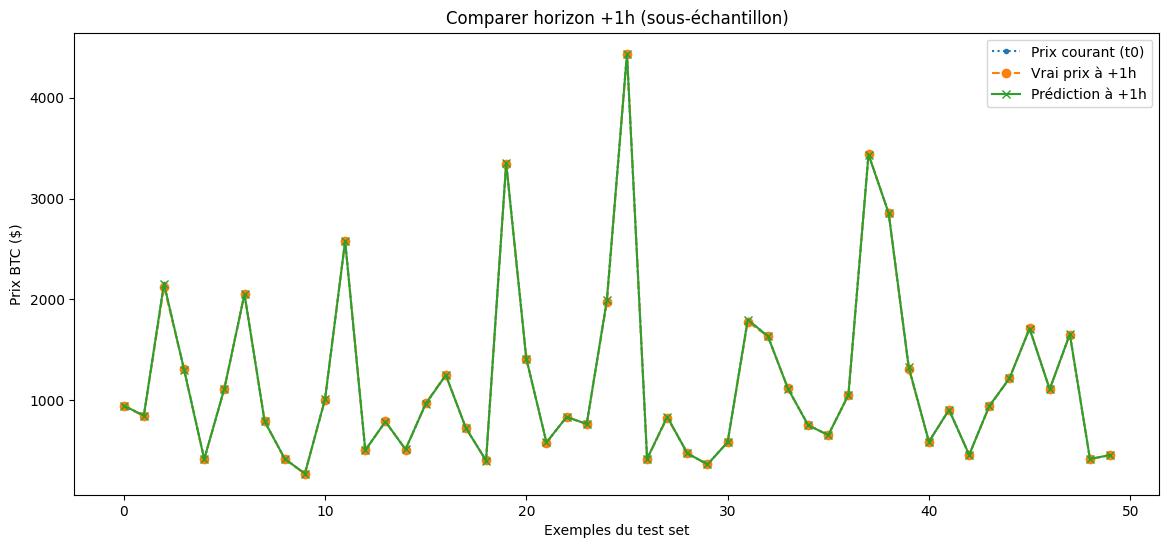

In [142]:
import matplotlib.pyplot as plt
import numpy as np

def plot_horizon_1h(Y_pred_real, Y_true_real, current_prices, n_samples=50):
    # Choisir un sous-échantillon d’indices
    idx = np.random.choice(len(Y_true_real), size=n_samples, replace=False)

    plt.figure(figsize=(14,6))
    plt.plot(current_prices[idx], label="Prix courant (t0)", linestyle=":", marker=".")
    plt.plot(Y_true_real[idx,0], label="Vrai prix à +1h", linestyle="--", marker="o")
    plt.plot(Y_pred_real[idx,0], label="Prédiction à +1h", linestyle="-", marker="x")
    
    plt.legend()
    plt.title("Comparer horizon +1h (sous-échantillon)")
    plt.xlabel("Exemples du test set")
    plt.ylabel("Prix BTC ($)")
    plt.show()

# Utilisation :
plot_horizon_1h(Y_pred_real, Y_true_real, current_prices, n_samples=50)


In [143]:
i = 0
print("Fenêtre 0")
print("Prix courant (t0):", current_prices[i])
print("Vrai prix +1h:", Y_true_real[i,0])

i = 1
print("\nFenêtre 1")
print("Prix courant (t0):", current_prices[i])
print("Vrai prix +1h:", Y_true_real[i,0])


Fenêtre 0
Prix courant (t0): 1536.3582
Vrai prix +1h: 1532.5596

Fenêtre 1
Prix courant (t0): 2533.2034
Vrai prix +1h: 2548.7747


In [155]:
def simulate_predictions_last_hours(model, df, input_len=168, horizon=1, target_col="close", hours=5):
    """
    Simule des prédictions consécutives sur les dernières `hours`.
    Exemple: si hours=5 et horizon=1h, on produit 5 prédictions (t+1)
    en utilisant les fenêtres de t passées.
    """
    feature_cols = [c for c in df.columns if c != target_col]
    data = df[feature_cols].values
    target = df[target_col].values

    # Point de départ : on garde juste les `hours` dernières heures
    start_idx = len(df) - hours - input_len

    X, current_prices, Y_true = [], [], []
    for t in range(start_idx, start_idx + hours):
        x_window = data[t-input_len:t]
        X.append(x_window)
        current_prices.append(target[t-1])  # prix à t
        Y_true.append(target[t + horizon - 1])  # vrai prix à t+1

    X = np.array(X, dtype=np.float32)
    X = (X - feat_mean) / feat_std  # normalisation

    # Prédictions
    Y_pred_rel = model.predict(X, batch_size=1, verbose=0)[:, horizon-1]
    Y_pred = (Y_pred_rel + 1) * np.array(current_prices)

    times = df.index[start_idx+1 : start_idx+1+hours]  # les points t+1
    return times, np.array(Y_true), np.array(Y_pred)


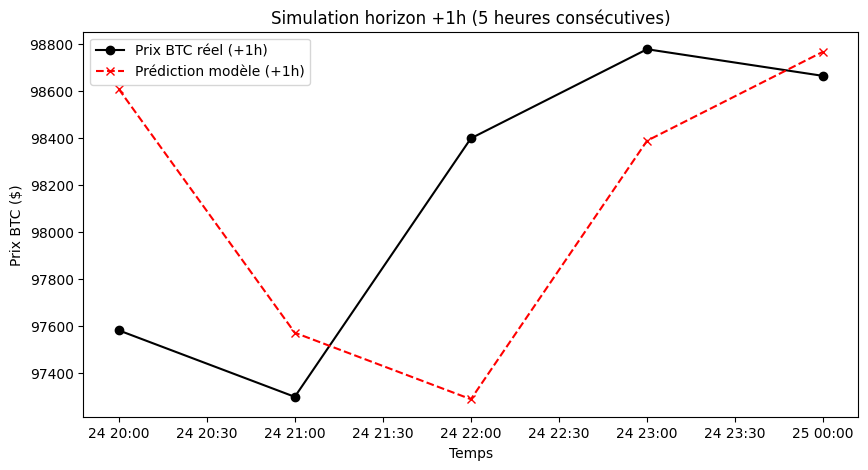

Vrai prix : [97581.09 97298.01 98397.96 98777.11 98663.58]
Prédictions : [98608.35563776 97570.89405028 97287.84362844 98387.67869803
 98766.78908181]


In [156]:
times, trues, preds = simulate_predictions_last_hours(model, df, input_len=168, horizon=1, hours=5)

plt.figure(figsize=(10,5))
plt.plot(times, trues, "o-", label="Prix BTC réel (+1h)", color="black")
plt.plot(times, preds, "x--", label="Prédiction modèle (+1h)", color="red")
plt.legend()
plt.title("Simulation horizon +1h (5 heures consécutives)")
plt.xlabel("Temps")
plt.ylabel("Prix BTC ($)")
plt.show()

print("Vrai prix :", trues)
print("Prédictions :", preds)


---

Précédente analyse biaisée

In [114]:
def denormalize_close(Y_pred, Y_true, feat_mean, feat_std, target_col="close", df=None):
    """
    Convertit les prédictions et vraies valeurs normalisées en prix réels.
    
    Y_pred : np.array (N, H) -> prédictions normalisées
    Y_true : np.array (N, H) -> vraies valeurs normalisées
    feat_mean, feat_std : stats utilisées pour normalisation
    target_col : colonne cible ("close")
    df : DataFrame originale (optionnel, juste pour vérifier)
    """
    # indice de la colonne target
    target_idx = list(df.columns).index(target_col) if df is not None else 0
    
    mean = feat_mean[0,0,target_idx]
    std = feat_std[0,0,target_idx]

    Y_pred_real = Y_pred * std + mean
    Y_true_real = Y_true * std + mean
    
    return Y_pred_real, Y_true_real


In [115]:
def eval_dollar_error(Y_pred_real, Y_true_real):
    mae = np.mean(np.abs(Y_true_real - Y_pred_real))
    rmse = np.sqrt(np.mean((Y_true_real - Y_pred_real)**2))
    return mae, rmse


In [116]:
# 1. Prédictions sur le set de test
Y_pred = model.predict(X_test_n, batch_size=32)

Y_pred_real, Y_true_real = denormalize_close(Y_pred, Y_test, feat_mean, feat_std, df)

mae_usd, rmse_usd = eval_dollar_error(Y_pred_real, Y_true_real)

# 4. Accuracy directionnelle
def eval_direction_accuracy(Y_pred_real, Y_true_real):
    real_dir = np.sign(np.diff(Y_true_real, axis=1))  # -1 baisse, +1 hausse
    pred_dir = np.sign(np.diff(Y_pred_real, axis=1))
    acc = np.mean(real_dir == pred_dir)
    return acc * 100

acc_dir = eval_direction_accuracy(Y_pred_real, Y_true_real)

# 5. Résultats
print(f"📊 Erreur moyenne absolue (MAE): {mae_usd:.2f} $")
print(f"📊 RMSE: {rmse_usd:.2f} $")
print(f"📈 Accuracy directionnelle: {acc_dir:.2f} %")

120/127 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2025-09-05 12:51:01.160887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2025-09-05 12:51:01.332336: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-09-05 12:51:01.453543: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 4 bytes spill stores, 4 bytes spill loads

2025-09-05 12:51:01.732423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 12 bytes spill stores, 12 bytes spill loads

2025-09-05 12:51:01.760774: I external/local_xla/xla/s

127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step
📊 Erreur moyenne absolue (MAE): 85.20 $
📊 RMSE: 167.78 $
📈 Accuracy directionnelle: 50.01 %


Premier test avec les 1 semaine:

Erreur moyenne absolue (MAE): 284.63 $ 

📊 RMSE: 543.51 $ 

📈 Accuracy directionnelle: 47.30 %


Deuxième test sans les 1 semaine mais avec les 24h:

📊 Erreur moyenne absolue (MAE): 145.73 $

📊 RMSE: 232.28 $

📈 Accuracy directionnelle: 49.77 %


In [130]:
def eval_direction_accuracy_by_horizon(Y_pred_real, Y_true_real, horizons=[1,3,6]):
    results = {}
    n_horizons = len(horizons)

    for i, h in enumerate(horizons):
        # Variation par rapport au prix courant (colonne 0 = horizon le plus proche)
        real_dir = np.sign(Y_true_real[:, i] - Y_true_real[:, 0])
        pred_dir = np.sign(Y_pred_real[:, i] - Y_pred_real[:, 0])
        acc = np.mean(real_dir == pred_dir) * 100

        results[h] = acc

    return results

results = eval_direction_accuracy_by_horizon(Y_pred_real, Y_true_real, horizons=[1,3,6])
for h, acc in results.items():
    print(f"⏩ Horizon {h}h - 📈 Direction accuracy: {acc:.2f} %")


⏩ Horizon 1h - 📈 Direction accuracy: 100.00 %
⏩ Horizon 3h - 📈 Direction accuracy: 47.99 %
⏩ Horizon 6h - 📈 Direction accuracy: 52.26 %


In [128]:
import numpy as np

target_idx = list(df.columns).index("close")
mean = feat_mean[0,0,target_idx]
std = feat_std[0,0,target_idx]

current_prices = X_test[:, -1, target_idx] * std + mean
for i, h in enumerate([1,3,6]):
    future_prices = Y_true_real[:, i]
    print(f"Horizon {h}h: % hausses = {np.mean(future_prices > current_prices)*100:.2f}%")


Horizon 1h: % hausses = 0.00%
Horizon 3h: % hausses = 0.00%
Horizon 6h: % hausses = 0.00%


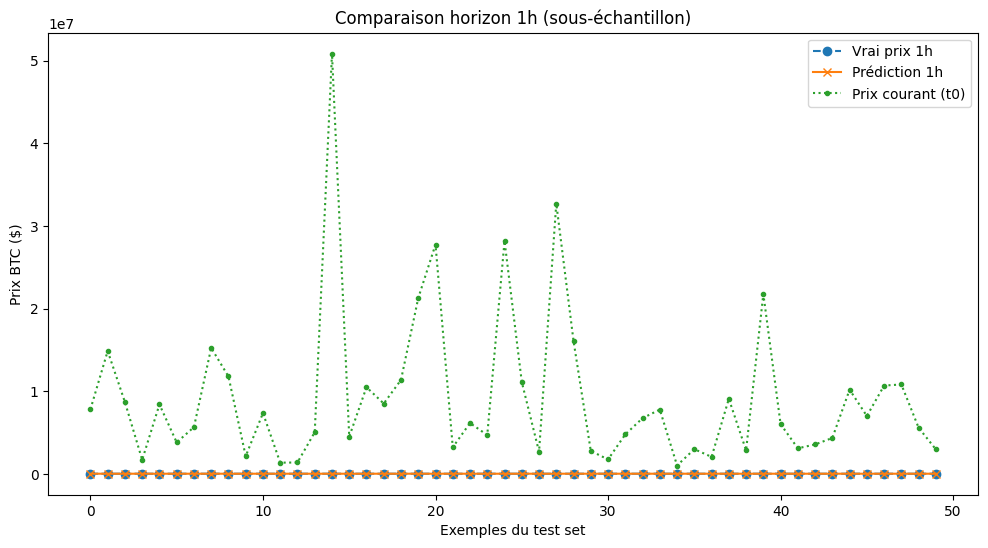

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_true_1h(Y_pred_real, Y_true_real, X_test, feat_mean, feat_std, df, n_samples=50):
    target_idx = list(df.columns).index("close")
    mean = feat_mean[0,0,target_idx]
    std = feat_std[0,0,target_idx]

    # Prix courant = dernier close de la fenêtre
    current_prices = X_test[:, -1, target_idx] * std + mean

    true_1h = Y_true_real[:, 0]
    pred_1h = Y_pred_real[:, 0]

    # Choisir un sous-échantillon pour visualiser
    idx = np.random.choice(len(true_1h), size=n_samples, replace=False)

    plt.figure(figsize=(12,6))
    plt.plot(true_1h[idx], label="Vrai prix 1h", marker="o", linestyle="--")
    plt.plot(pred_1h[idx], label="Prédiction 1h", marker="x", linestyle="-")
    plt.plot(current_prices[idx], label="Prix courant (t0)", marker=".", linestyle=":")
    plt.legend()
    plt.title("Comparaison horizon 1h (sous-échantillon)")
    plt.xlabel("Exemples du test set")
    plt.ylabel("Prix BTC ($)")
    plt.show()

# Utilisation :
plot_pred_vs_true_1h(Y_pred_real, Y_true_real, X_test, feat_mean, feat_std, df, n_samples=50)


In [ ]:
def reconvert_to_prices(Y_pred, Y_true, X_test, feat_mean, feat_std, df):
    # Identifier l’index de la colonne 'close'
    target_idx = list(df.columns).index("close")
    mean = feat_mean[0,0,target_idx]
    std = feat_std[0,0,target_idx]

    # Prix courant = dernier close de chaque fenêtre (dénormalisé)
    current_prices = X_test[:, -1, target_idx] * std + mean  # shape (N,)

    # Reconstruire les prix réels
    Y_true_real = (Y_true + 1) * current_prices[:, None]
    Y_pred_real = (Y_pred + 1) * current_prices[:, None]

    return Y_pred_real, Y_true_real, current_prices




IndentationError: unindent does not match any outer indentation level (<string>, line 118)

In [134]:
def reconvert_to_prices(Y_pred, Y_true, X_test, feat_mean, feat_std, df):
    # Identifier l’index de la colonne 'close'
    target_idx = list(df.columns).index("close")
    mean = feat_mean[0,0,target_idx]
    std = feat_std[0,0,target_idx]

    # Prix courant = dernier close de chaque fenêtre (dénormalisé)
    current_prices = X_test[:, -1, target_idx] * std + mean  # shape (N,)

    # Reconstruire les prix réels
    Y_true_real = (Y_true + 1) * current_prices[:, None]
    Y_pred_real = (Y_pred + 1) * current_prices[:, None]

    return Y_pred_real, Y_true_real, current_prices

Y_pred_real, Y_true_real, current_prices = reconvert_to_prices(
    Y_pred, Y_true, X_test_n, feat_mean, feat_std, df
)

# Exemple : affichons horizon 1h
print("Prix courant :", current_prices[:5])
print("Vrai prix 1h :", Y_true_real[:5,0])
print("Prédiction 1h :", Y_pred_real[:5,0])


NameError: name 'Y_true' is not defined